分析目标:
1. 定位低转化环节,给出运营优化建议。
2. 针对珠宝直播用户特性调整 RFM 指标，划分高价值 / 潜力 / 流失等用户层级，给出不同层级的运营策略。
3. 分析和田玉 / 翡翠,核心品类的销量、客单价、转化率差异，用简单线性回归做爆款单品的短期销量预测，为公司选品、直播间排品提供数据支撑。

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')  
plt.rcParams['font.sans-serif']=['simhei'] 

In [2]:
df = pd.read_csv('珠宝直播模拟数据_5000条_差异版.csv')
df.head(5)  

,直播间ID,商品ID,品类,商品名称,商品类型,标价(元),直播平台,主播ID,开播时长(分钟),观看人数(人),商品点击人数(人),支付人数(人),最近下单时间(天),下单频次(次),商品销量(件)
0,ZB_0187,CP_1563,和田玉,白玉和田玉无事牌款,无事牌,20698.0,抖音,A04,80,2775,369,7,3,1,7
1,ZB_0131,CP_0973,和田玉,羊脂玉和田玉无事牌款,无事牌,19975.0,快手,A09,124,826,75,1,32,2,1
2,ZB_0045,CP_1190,和田玉,白玉和田玉手串收藏级,手串,15377.0,抖音,A06,38,8816,1235,30,37,1,30
3,ZB_0143,CP_4653,和田玉,羊脂玉和田玉手串款,手串,22418.0,快手,A06,72,8001,759,18,14,1,18
4,ZB_0149,CP_2905,翡翠,冰种翡翠吊坠入门级,吊坠,10454.0,快手,A01,142,8375,889,53,72,1,106


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   直播间ID      3500 non-null   object 
 1   商品ID       3500 non-null   object 
 2   品类         3500 non-null   object 
 3   商品名称       3500 non-null   object 
 4   商品类型       3500 non-null   object 
 5   标价(元)      3500 non-null   float64
 6   直播平台       3500 non-null   object 
 7   主播ID       3500 non-null   object 
 8   开播时长(分钟)   3500 non-null   int64  
 9   观看人数(人)    3500 non-null   int64  
 10  商品点击人数(人)  3500 non-null   int64  
 11  支付人数(人)    3500 non-null   int64  
 12  最近下单时间(天)  3500 non-null   int64  
 13  下单频次(次)    3500 non-null   int64  
 14  商品销量(件)    3500 non-null   int64  
dtypes: float64(1), int64(7), object(7)
memory usage: 410.3+ KB


In [4]:
df.isnull().sum()

直播间ID        0
商品ID         0
品类           0
商品名称         0
商品类型         0
标价(元)        0
直播平台         0
主播ID         0
开播时长(分钟)     0
观看人数(人)      0
商品点击人数(人)    0
支付人数(人)      0
最近下单时间(天)    0
下单频次(次)      0
商品销量(件)      0
dtype: int64

In [5]:
df.describe()

,标价(元),开播时长(分钟),观看人数(人),商品点击人数(人),支付人数(人),最近下单时间(天),下单频次(次),商品销量(件)
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.00000
mean,21606.830000,106.474000,5218.802000,624.613429,20.820000,45.324857,1.190571,27.74800
std,12642.814206,43.921201,2729.245434,362.248290,15.666999,26.283871,0.392808,24.13962
min,1010.000000,30.000000,501.000000,44.000000,1.000000,1.000000,1.000000,1.00000
25%,11371.250000,68.000000,2792.750000,323.000000,9.000000,22.000000,1.000000,11.00000
50%,20254.000000,107.000000,5233.000000,597.500000,17.000000,46.000000,1.000000,21.00000
75%,29180.000000,146.000000,7544.750000,864.000000,29.000000,68.000000,1.000000,37.00000
max,49974.000000,180.000000,9999.000000,1556.000000,97.000000,90.000000,2.000000,174.00000


#### 一、 进行漏斗分析

计算 “观看→点击→支付” 全链路转化率，对比分品类 / 分平台差异,给出运营优化建议

In [6]:

df["商品点击率"] = df["商品点击人数(人)"]/df["观看人数(人)"]

df["支付转化率"] = df["支付人数(人)"]/df["商品点击人数(人)"]

df["整体转化率"] = df["支付人数(人)"]/df["观看人数(人)"]


print("=== 以下数据皆为平均值 ===")
print("\n=== 全平台各转化率 ===")
funnel_overall = {'环节':["观看人数","商品点击率",
                       "支付转化率","整体转化率"],
                 '数值':[f'{df["观看人数(人)"].mean():.03f}人',
                        f'{df["商品点击率"].mean():.1%}',
                       f'{df["支付转化率"].mean():.1%}',
                       f'{df["整体转化率"].mean():.1%}'
                      ]}


funnel_overall_df = pd.DataFrame(funnel_overall)
print(funnel_overall_df)


print("\n=== 分品类各转化率 ===")
category_funnel = df.groupby('品类')[['商品点击率',
                       '支付转化率','整体转化率']].mean().round(3)
category_funnel = category_funnel.applymap(lambda x: f"{x:.1%}")
print(category_funnel)

print("\n=== 分平台各转化率 ===")
platform_funnel = df.groupby('直播平台')[['商品点击率', '支付转化率', '整体转化率']].mean().round(3)
platform_funnel = platform_funnel.applymap(lambda x: f"{x:.1%}")
print(platform_funnel)

=== 以下数据皆为平均值 ===

=== 全平台各转化率 ===
      环节         数值
0   观看人数  5218.802人
1  商品点击率      12.0%
2  支付转化率       3.3%
3  整体转化率       0.4%

=== 分品类各转化率 ===
     商品点击率 支付转化率 整体转化率
品类                    
和田玉  12.0%  2.1%  0.3%
翡翠   11.9%  4.4%  0.5%

=== 分平台各转化率 ===
      商品点击率 支付转化率 整体转化率
直播平台                   
快手     9.5%  3.2%  0.3%
抖音    14.5%  3.3%  0.5%


以上结果解释:

- 全平台各转化率:
1. 观看平均人数有5218.802人,流量较为充足。
2. 商品点击率12.0%:反映直播间引流与商品展示不够吸引客户,需要改进。
3. 支付转化率3.3%:反映用户点击商品后支付率低,需要加强进入商品界面的吸引力,加强产品力。
4. 整体转化率0.4%:整体转化率太低了,每1000人只能转化4人,接触用户的环节都要加强。

- 分品类各转化率:
1. 和田玉:和田玉的商品点击率与翡翠相当,但支付转化率和整体转化率都相较低,主要是支付转化率出现问题,有待加强。
2. 翡翠:支付转化率比和田玉显著要高,可重点运营,投入资源可多点。

- 分平台各转化率:
1. 快手: 商品点击率相比较低,快手平台的直播间效果明显比抖音差;整体转化率相比较低,快手平台引流效果相比较低。
2. 抖音：商品点击率相比较高,抖音平台的直播间效果明显比快手好；整体转化率相比较高,抖音平台引流效果相比较高,可以加强对抖音平台的投资运营。

- 整体业务优化建议
1. 全链路策略: 重点加强支付转化率、整体转化率(如加强产品力,优化下单流程,增加限时福利等),也要提高商品点击率（如发放优惠卷,优化直播间视觉呈现、增加互动、优化直播间标题、加强引流等）,实现走进来，买下来两手捉。
2. 品类策略: 加强对翡翠的资源投入,同时可以对和田玉进行诊断(如用户调研,A/B测试等),缩小与翡翠的差距。
3. 平台策略: 加强对抖音的资源投入,同时加强快手平台的直播间效果,实现双平台协同增收。

#### 二、可视化 RFM 用户分层分析,各层级用户核心特征分析,用户层级贡献值

In [7]:
df['累计消费金额(元)'] = df['标价(元)']*df['商品销量(件)']
rfm_df = df.groupby('商品ID').agg({'最近下单时间(天)':'min','下单频次(次)':'sum',
                                '累计消费金额(元)':'sum'}).reset_index()
rfm_df.columns = ['用户ID', '最近下单时间(R)', '下单频次(F)', '累计消费金额(M)']

rfm_df['R分'] = pd.qcut(rfm_df['最近下单时间(R)'], 5, labels=[5, 4, 3, 2, 1])
rfm_df['F分'] = pd.cut(rfm_df['下单频次(F)'], bins=[0, 1, 2, 10], labels=[3, 4, 5])
rfm_df['M分'] = pd.qcut(rfm_df['累计消费金额(M)'], 5, labels=[1, 2, 3, 4, 5])

rfm_df['R分_数值'] = rfm_df['R分'].astype(int)
rfm_df['F分_数值'] = rfm_df['F分'].astype(int)
rfm_df['M分_数值'] = rfm_df['M分'].astype(int)
rfm_df['RFM总分'] = (rfm_df['R分_数值'] * 0.3) + (rfm_df['F分_数值'] * 0.2) + (rfm_df['M分_数值'] * 0.5)

def user_segment(score):
    if score >=4.5 :
        return '1.高价值核心用户'
    elif score >=3.5 :
        return '2.潜力高客单用户' 
    elif score >=2.5 :
        return '3.新用户'
    elif score >=1.5 :
        return '4.流失潜力用户'
    else:
        return '5.流失低价值用户' 

rfm_df['用户层级'] = rfm_df['RFM总分'].apply(user_segment)


print("=== RFM用户分层分布 ===")
user_segment_dist = rfm_df['用户层级'].value_counts(normalize=True)

user_segment_dist_pct = user_segment_dist.map(lambda x: f'{x:.1%}')
print(user_segment_dist_pct)


=== RFM用户分层分布 ===
用户层级
3.新用户        35.1%
2.潜力高客单用户    27.8%
4.流失潜力用户     23.3%
1.高价值核心用户    10.0%
5.流失低价值用户     3.8%
Name: proportion, dtype: object


In [8]:

gmv = sum(df["标价(元)"]*df["商品销量(件)"])
gmv

2315786418.0

In [9]:
print("\n=== 各层级用户核心特征 ===")
user_segment_features = rfm_df.groupby('用户层级').agg({'最近下单时间(R)': 'mean',
                                                        '下单频次(F)': 'mean',
                                                        '累计消费金额(M)': 'mean',
                                                   }).round(2)

user_segment_features['最近下单时间(R)(均值)'] = user_segment_features['最近下单时间(R)']
user_segment_features['下单频次(F)(均值)'] = user_segment_features['下单频次(F)']
user_segment_features['累计消费金额(M)(均值)'] = user_segment_features['累计消费金额(M)']

user_segment_features['层级消费总额'] =  rfm_df.groupby('用户层级').agg({'累计消费金额(M)':'sum'}).round(2)
user_segment_features['层级消费占总销售额比例'] = (user_segment_features['层级消费总额'] / gmv).round(4)
user_segment_features['层级消费占总销售额比例'] = user_segment_features['层级消费占总销售额比例'].map(lambda x: f'{x:.2%}')

user_segment_features = user_segment_features.drop(columns=['最近下单时间(R)','下单频次(F)','累计消费金额(M)'])
user_segment_features


=== 各层级用户核心特征 ===


,最近下单时间(R)(均值),下单频次(F)(均值),累计消费金额(M)(均值),层级消费总额,层级消费占总销售额比例
用户层级,,,,,
1.高价值核心用户,12.33,2.79,2470076.54,6.224593e+08,26.88%
2.潜力高客单用户,29.18,1.99,1495658.38,1.046961e+09,45.21%
3.新用户,40.59,1.43,588722.38,5.192531e+08,22.42%
4.流失潜力用户,57.94,1.23,203986.76,1.195362e+08,5.16%
5.流失低价值用户,79.89,1.00,78925.86,7.576883e+06,0.33%


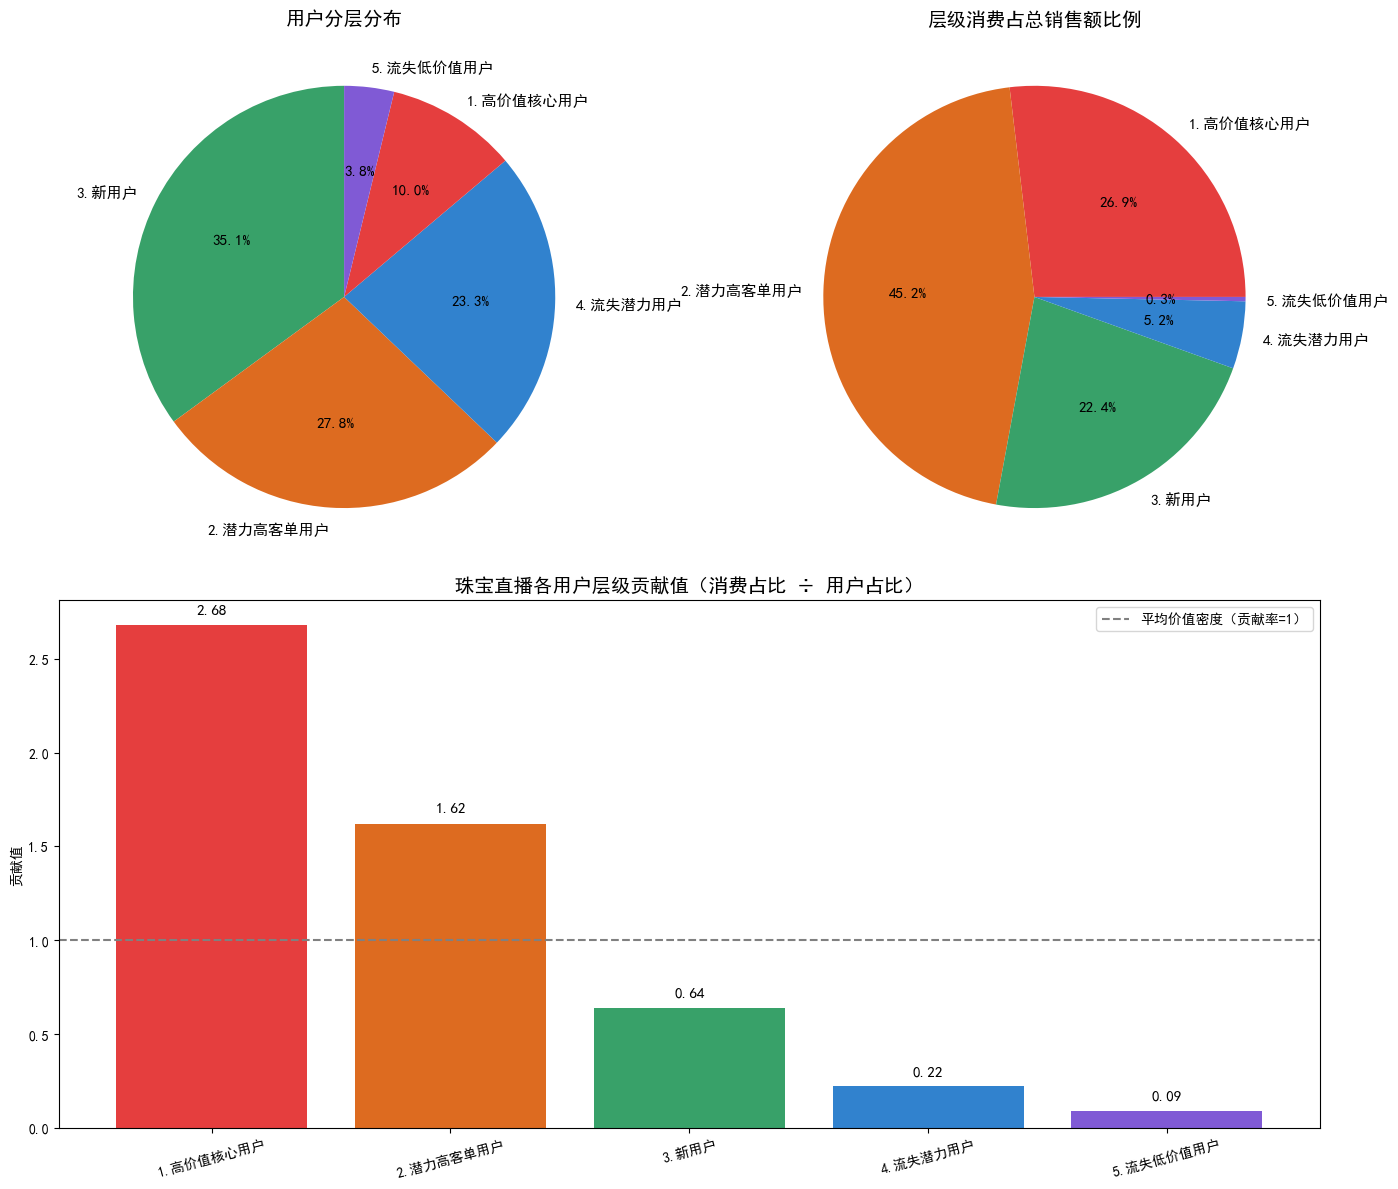

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14, 12))

gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

colors1 = [color_map[label] for label in user_segment_dist.index]
ax1.pie(
    user_segment_dist,
    labels=user_segment_dist.index,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 11},
    colors=colors1
)
ax1.set_title('用户分层分布', fontsize=14, fontweight='bold')
consumption_ratio = (user_segment_features['层级消费总额'] / gmv).round(4)
colors2 = [color_map[label] for label in user_segment_features.index]
ax2.pie(
    consumption_ratio,
    labels=user_segment_features.index,
    autopct='%1.1f%%',
    textprops={'fontsize': 11},
    colors=colors2
)
ax2.set_title('层级消费占总销售额比例', fontsize=14, fontweight='bold')

user_dist = user_segment_dist
consumption_ratio = (user_segment_features['层级消费总额'] / gmv).round(4)
contribution_rate = consumption_ratio / user_dist
contribution_rate = contribution_rate.round(2)
colors3 = [color_map[label] for label in contribution_rate.index]
bars = ax3.bar(contribution_rate.index, contribution_rate.values, color=colors3)
ax3.axhline(y=1, color='gray', linestyle='--', label='平均价值密度（贡献率=1）')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.05,
             f'{height:.2f}', ha='center', va='bottom', fontsize=11)


ax3.set_title('珠宝直播各用户层级贡献值（消费额占比 ÷ 用户占比）', fontsize=14, fontweight='bold')
ax3.set_ylabel('贡献值')
ax3.tick_params(axis='x', rotation=15)
ax3.legend()

fig.tight_layout()  
plt.show()

以上结果解释:

1. 高价值核心用户(红色)：
    - 用户规模小(10%),但用户贡献值高(2.68)(客单价、复购率极高),是所有客户群体最理想转化的方向。
    - 运营建议：深度维护+延长生命周期;
    - 具体策略：专属客服 + 新品优先品鉴 + 线下沙龙 + 定期回访。
2. 潜力高客单用户（橙色）:
    - 用户规模第二，消费贡献 45.2%（近一半销售额），贡献值 1.62,有消费能力但尚未形成稳定复购;这是当前销售额的第一支柱，同时也是高价值核心用户的 “储备池”，有消费能力但尚未形成稳定复购。
    - 运营建议：定向转化 + 提升复购；
    - 具体策略：高客单商品推送 + VIP 专属权益 + 开播提醒 + 社群沉淀新用户
3. 新用户(绿色):
    - 用户规模最大，但消费贡献仅22.4%，贡献值0.64,客单价偏低,复购次数少。
    - 运营建议：把新用户转化应该定位为运营第一目标，业务的重点;新用户用户规模最大,但只有贡献率0.64,一但转化升级用户成功,贡献率的增长是3到4倍,对销售额的增长(理想状态下)是40%-60%,杠杆效应大，投入资源应该最大。
    - 具体策略：新人专享套餐 + 直播引导 + 社群运营 + 复购优惠券
4. 流失潜力用户（蓝色）:
    - 用户数量第三，但消费贡献仅 5.2%，贡献值 0.22（价值密度远低于平均水平）,有消费历史但近期未下单。
    - 运营建议：精准唤醒 + 提升粘性
    - 具体策略：个性化开播提醒 + 历史商品推荐 + 专属优惠券 + 复购激励
5. 流失低价值用户（紫色）:
    - 用户数量最少，消费贡献仅 0.3%，贡献率 0.09（价值密度可忽略）。
    - 运营建议：投入产出比极低，无需重点资源投入，可自然流失。

整体业务结论:
1. 做好防守:基本盘运营
2. 组织进攻:新用户的转化升级


#### 三、品类爆款分析 + 线性回归销量预测（支撑选品决策）

核心目标:

分析翡翠 / 和田玉 / 找出爆款单品;用线性回归预测销量，为直播间选品、排品提供数据支撑（贴合公司主营品类，体现建模能力）。

In [11]:
df['销售额(元)']=df['标价(元)'] * df['商品销量(件)']

category_sales = df.groupby('品类').agg({
    '商品销量(件)': 'sum',          
    '标价(元)': 'mean',            
    '销售额(元)': 'sum',  
    '支付转化率': 'mean'           
}).reset_index()
category_sales

,品类,商品销量(件),标价(元),销售额(元),支付转化率
0,和田玉,30552,15390.318857,4.764602e+08,0.020917
1,翡翠,66566,27823.341143,1.839326e+09,0.044489


In [34]:

print("\n=== 翡翠品类TOP10爆款单品（按销售额） ===")
jade_top10 = df[df['品类']=='翡翠'].assign( 
    销售额=df['标价(元)'] * df['商品销量(件)']
).sort_values('销售额', ascending=False).head(10)[['商品名称', '商品类型', '标价(元)', '商品销量(件)', '销售额']]
jade_top10.round(2)


=== 翡翠品类TOP10爆款单品（按销售额） ===


,商品名称,商品类型,标价(元),商品销量(件),销售额
2949,冰种翡翠吊坠款,吊坠,44141.0,174,7680534.0
1864,冰种翡翠平安扣入门级,平安扣,49221.0,150,7383150.0
1955,冰种翡翠吊坠收藏级,吊坠,45034.0,146,6574964.0
2159,帝王绿翡翠平安扣款,平安扣,49683.0,128,6359424.0
856,帝王绿翡翠吊坠款,吊坠,48132.0,132,6353424.0
2310,帝王绿翡翠平安扣收藏级,平安扣,49447.0,128,6329216.0
3154,冰种翡翠平安扣收藏级,平安扣,46582.0,134,6241988.0
1589,帝王绿翡翠吊坠款,吊坠,46454.0,128,5946112.0
683,帝王绿翡翠平安扣款,平安扣,43943.0,130,5712590.0
1508,帝王绿翡翠平安扣入门级,平安扣,43048.0,132,5682336.0


In [33]:
print("\n=== 和田玉品类TOP10爆款单品（按销售额） ===")
jade_top10 = df[df['品类']=='和田玉'].assign( 
    销售额=df['标价(元)'] * df['商品销量(件)']
).sort_values('销售额', ascending=False).head(10)[['商品名称', '商品类型', '标价(元)', '商品销量(件)', '销售额']]
jade_top10.round(2)


=== 和田玉品类TOP10爆款单品（按销售额） ===


,商品名称,商品类型,标价(元),商品销量(件),销售额
3126,羊脂玉和田玉手串款,手串,26637.0,68,1811316.0
1243,羊脂玉和田玉手串入门级,手串,24006.0,72,1728432.0
2896,羊脂玉和田玉手串款,手串,25351.0,64,1622464.0
2450,羊脂玉和田玉无事牌款,无事牌,29728.0,54,1605312.0
334,白玉和田玉手串款,手串,25760.0,62,1597120.0
386,羊脂玉和田玉无事牌入门级,无事牌,24685.0,64,1579840.0
1352,白玉和田玉手串入门级,手串,29992.0,52,1559584.0
2886,白玉和田玉手串入门级,手串,25158.0,58,1459164.0
2567,白玉和田玉手串入门级,手串,25084.0,58,1454872.0
896,羊脂玉和田玉无事牌款,无事牌,22597.0,64,1446208.0


- 使用线性回归预测销量


=== 线性回归模型评估 ===
R²（拟合度）：0.645
MAE（平均绝对误差）：10.87件

=== 特征重要性（系数越大，对销量正向影响越强） ===
           特征       系数   P值
10      品类_翡翠  13.3958  0.0
3   商品点击人数(人)   0.0115  0.0
5    开播时长(分钟)   0.0115  0.0
2   商品点击人数(人)   0.0115  0.0
4       标价(元)   0.0115  0.0
14   商品类型_无事牌  -6.8359  0.0
12    商品类型_手串  -7.5676  0.0


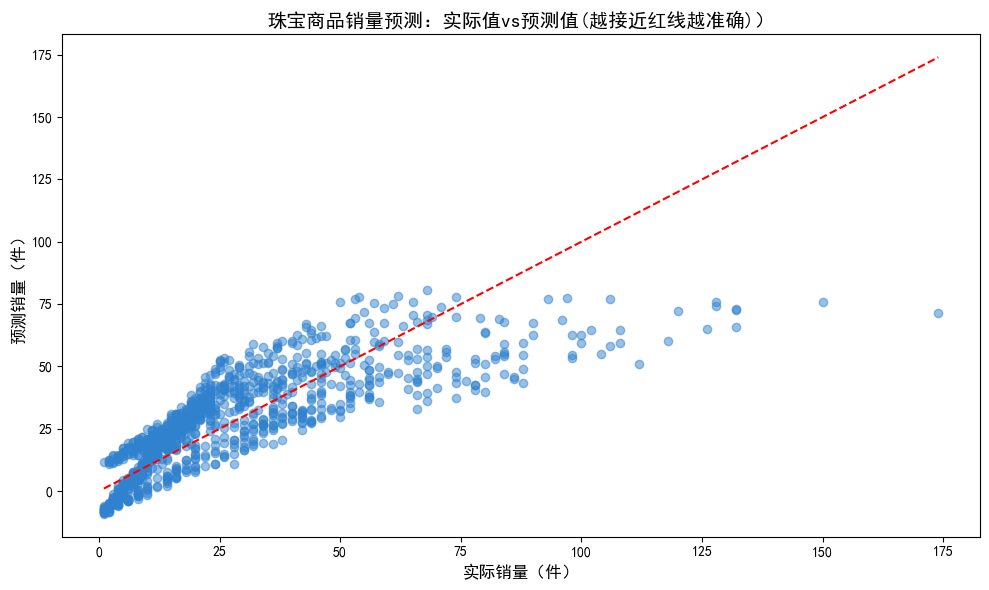

In [29]:
model_df = df[['观看人数(人)','商品点击人数(人)','商品点击人数(人)','标价(元)','最近下单时间(天)','下单频次(次)',
               '开播时长(分钟)','直播平台', '品类', '商品类型', '商品销量(件)']].copy()
encoder = OneHotEncoder(sparse_output=False, drop='first')  
cat_features = encoder.fit_transform(model_df[['品类', '商品类型','直播平台']])  
cat_feature_names = encoder.get_feature_names_out(['品类','商品类型','直播平台'])  

num_features = model_df[['观看人数(人)','商品点击人数(人)','商品点击人数(人)', '标价(元)', '开播时长(分钟)',
                         '最近下单时间(天)','下单频次(次)']].values  
X = np.hstack([num_features, cat_features])  
y = model_df['商品销量(件)'].values  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=666)

X_train_sm = sm.add_constant(X_train)  
model = sm.OLS(y_train, X_train_sm).fit()  

X_test_sm = sm.add_constant(X_test)
y_pred = model.predict(X_test_sm)  
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("\n=== 线性回归模型评估 ===")
print(f"R²（拟合度）：{r2:.3f}")  
print(f"MAE（平均绝对误差）：{mae:.2f}件")

num_cols = num_features.shape[1]
cat_cols = cat_features.shape[1]

numeric_feature_names = [
    '观看人数(人)', '商品点击人数(人)', '商品点击人数(人)', '标价(元)', '开播时长(分钟)', '最近下单时间(天)', '下单频次(次)',
    '补充特征1',  '补充特征2']
assert len(numeric_feature_names) == num_cols, "数值特征名数量不匹配！"

feature_names = ['常数项'] + numeric_feature_names + list(cat_feature_names)

assert len(feature_names) == len(model.params), "特征名长度与系数数量不匹配！"

coef_df = pd.DataFrame({
    '特征': feature_names,
    '系数': model.params.round(4),
    'P值': model.pvalues.round(4)
}).sort_values('系数', ascending=False)

print("\n=== 特征重要性（系数越大，对销量正向影响越强） ===")
print(coef_df[coef_df['P值'] < 0.05])

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_test, y_pred, alpha=0.5, color='
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  
ax.set_xlabel('实际销量（件）', fontsize=12)
ax.set_ylabel('预测销量（件）', fontsize=12)
ax.set_title(f'珠宝商品销量预测：实际值vs预测值(越接近红线越准确)）', fontsize=14, fontweight='bold')
plt.show()

一、模型整体表现评估

- R²（拟合度）= 0.645
模型能够解释 64.5% 的销量变化，在业务场景中属于中等偏上的拟合效果，说明模型具备一定的预测能力，但仍有提升空间。
- MAE（平均绝对误差）= 10.87 件
模型预测值与实际值的平均偏差约为 11 件，对于珠宝这类客单价高、销量波动较大的品类来说，这个误差水平可以接受，但对高销量商品的预测精度还有优化空间。

二、特征重要性解读
1. 正向影响最强的特征
- 品类_翡翠（系数 = 13.3958）：翡翠品类对销量的正向拉动作用最强，是最显著的 “爆款品类”，说明翡翠在当前直播场景中最受用户欢迎。
- 商品点击人数、开播时长、标价（系数≈0.0115）：这些指标对销量有显著的正向影响，说明流量质量（点击人数）、直播时长、合理定价是提升销量的关键运营动作。

2. 负向影响最强的特征
- 商品类型_手串（系数 =-7.5676）：手串类型对销量有明显的负向抑制作用，是最 “拖后腿” 的商品类型。
- 商品类型_无事牌（系数 =-6.8359）：无事牌类型同样对销量有显著的负向影响。这说明手串和无事牌在当前的选品或直播策略下，用户接受度较低，需要调整。

三、业务启示与优化建议
1. 品类与选品策略
- 重点发力翡翠品类：加大翡翠商品的选品和直播资源倾斜，打造更多爆款，最大化正向收益。
- 优化手串与无事牌：减少低转化的手串和无事牌的直播场次，或调整其定价、直播话术，测试是否能提升销量；若效果不佳，可考虑缩减该类商品的库存。
2. 运营动作优化
- 提升流量质量：通过优化封面、标题等方式，提升商品点击人数，直接拉动销量。
- 延长有效开播时长：在用户活跃时段适当延长直播时长，增加曝光机会。
- 精细化定价：利用标价对销量的正向影响，结合用户画像和竞品数据，制定更精准的价格策略。